# 구내식당 식사인원 예측

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import holidays
import datetime
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# 사용자 운영체제 확인
import os
os.name

# 운영체제별 한글 폰트 설정
if os.name == 'posix': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

# Dataset

In [3]:
train = pd.read_csv("./data/weather_corona_train.csv", encoding='cp949')
test = pd.read_csv("./data/weather_corona_test.csv", encoding='cp949')

train = train.iloc[:,1:]
test = test.iloc[:,1:]

In [5]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,평균기온(°C),일강수량(mm),평균 지면온도(°C),확진자수
0,2016-02-01,월,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,-0.6,NaN,2.3,0
1,2016-02-02,화,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,-2.3,NaN,1.2,0
2,2016-02-03,수,2601,56,180,111,0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573,-1.7,NaN,1.3,0
3,2016-02-04,목,2601,104,220,355,0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525,-0.2,NaN,1.0,0
4,2016-02-05,금,2601,278,181,34,0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,1.3,NaN,2.4,0


# 전처리 및 EDA

## EDA

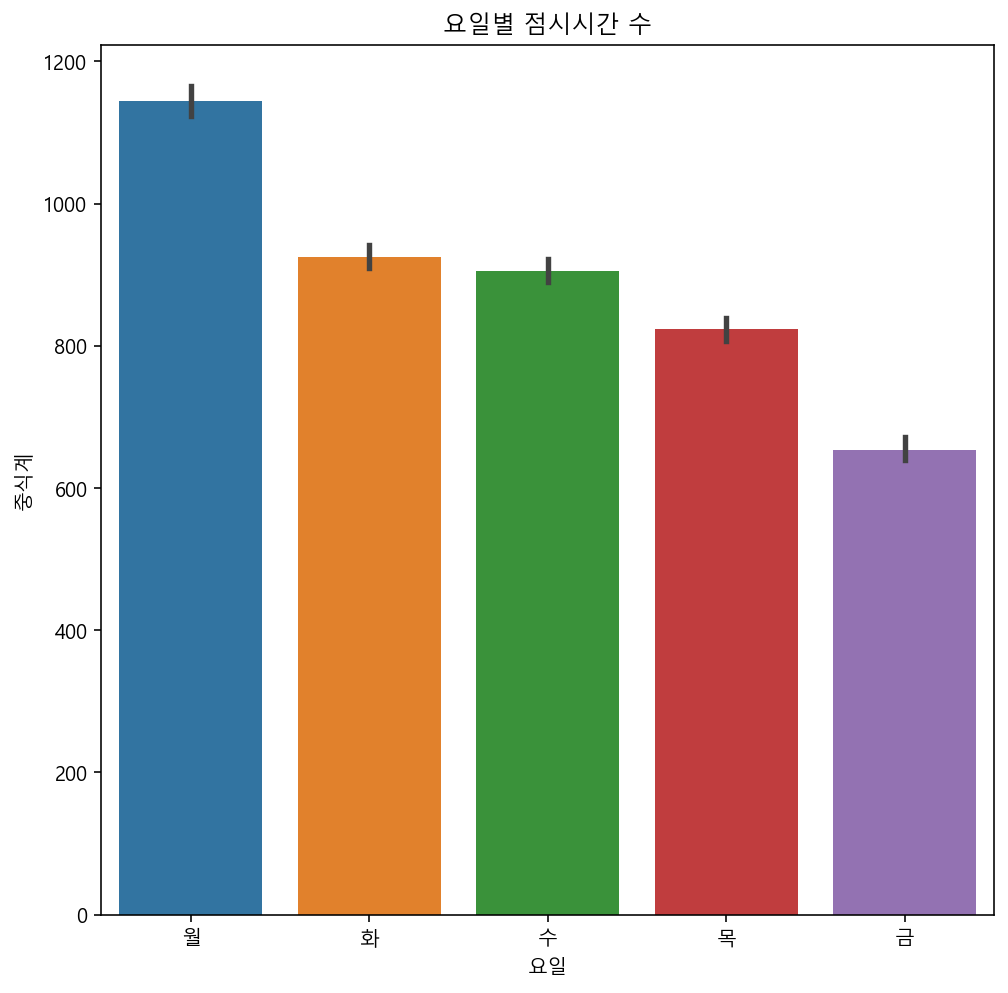

In [6]:
plt.figure(figsize=(8,8))


sns.barplot(x="요일", y="중식계", data=train)
plt.title("요일별 점시시간 수")
plt.show()

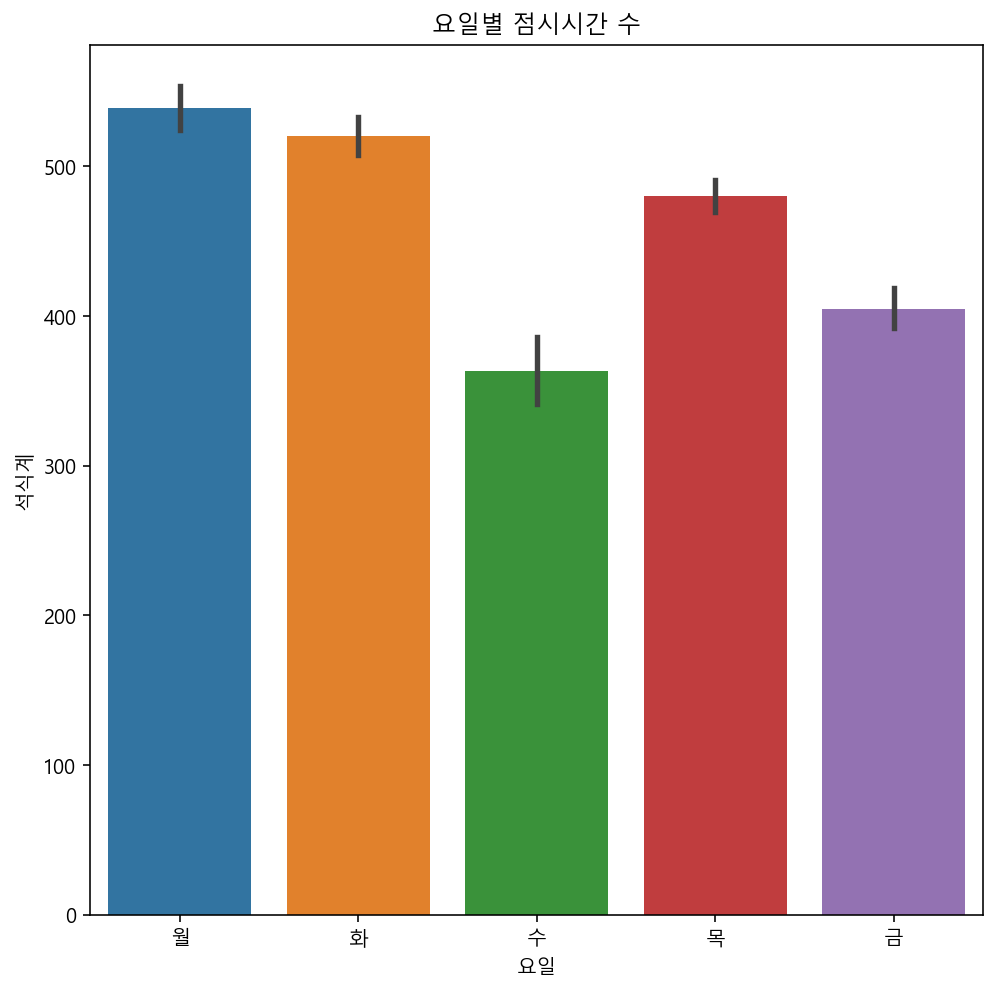

In [7]:
plt.figure(figsize=(8,8))


sns.barplot(x="요일", y="석식계", data=train)
plt.title("요일별 점시시간 수")
plt.show()

## 날씨

In [10]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '평균기온(°C)',
       '일강수량(mm)', '평균 지면온도(°C)', '확진자수'],
      dtype='object')

In [8]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,평균기온(°C),일강수량(mm),평균 지면온도(°C),확진자수
0,2016-02-01,월,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,-0.6,NaN,2.3,0
1,2016-02-02,화,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,-2.3,NaN,1.2,0
2,2016-02-03,수,2601,56,180,111,0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573,-1.7,NaN,1.3,0
3,2016-02-04,목,2601,104,220,355,0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525,-0.2,NaN,1.0,0
4,2016-02-05,금,2601,278,181,34,0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,1.3,NaN,2.4,0


In [11]:
train.drop(['평균 지면온도(°C)'], axis=1, inplace=True)
test.drop(['평균 지면온도(°C)'], axis=1, inplace=True)

In [ ]:
print('train\n', train.loc[:,['평균기온(°C)','일강수량(mm)']].isnull().sum(), '\n')
print('test\n', test.loc[:,['평균기온(°C)','일강수량(mm)']].isnull().sum())

In [20]:
train['평균기온(°C)'].fillna(method='ffill', inplace=True)

In [22]:
train['일강수량(mm)'].fillna(0, inplace=True)
test['일강수량(mm)'].fillna(0, inplace=True)

In [31]:
print('train\n', train.loc[:,['평균기온(°C)','일강수량(mm)']].isnull().sum(), '\n')
print('test\n', test.loc[:,['평균기온(°C)','일강수량(mm)']].isnull().sum())

train
 평균기온(°C)    0
일강수량(mm)    0
dtype: int64 

test
 평균기온(°C)    0
일강수량(mm)    0
dtype: int64


## 휴일 & 공휴일 전 후

In [32]:
holiday_list = [] 
for i in range(2016,2022):
    for date in holidays.KR(years=i).keys():  # 한국 공휴일 가져오기
        holiday_list.append(date)

In [33]:
holiday_list

[datetime.date(2016, 1, 1),
 datetime.date(2016, 2, 7),
 datetime.date(2016, 2, 8),
 datetime.date(2016, 2, 9),
 datetime.date(2016, 2, 10),
 datetime.date(2016, 3, 1),
 datetime.date(2016, 5, 14),
 datetime.date(2016, 5, 5),
 datetime.date(2016, 5, 1),
 datetime.date(2016, 6, 6),
 datetime.date(2016, 8, 15),
 datetime.date(2016, 9, 14),
 datetime.date(2016, 9, 15),
 datetime.date(2016, 9, 16),
 datetime.date(2016, 10, 3),
 datetime.date(2016, 10, 9),
 datetime.date(2016, 12, 25),
 datetime.date(2017, 1, 1),
 datetime.date(2017, 1, 27),
 datetime.date(2017, 1, 28),
 datetime.date(2017, 1, 29),
 datetime.date(2017, 1, 30),
 datetime.date(2017, 3, 1),
 datetime.date(2017, 5, 3),
 datetime.date(2017, 5, 5),
 datetime.date(2017, 5, 1),
 datetime.date(2017, 6, 6),
 datetime.date(2017, 8, 15),
 datetime.date(2017, 10, 3),
 datetime.date(2017, 10, 4),
 datetime.date(2017, 10, 5),
 datetime.date(2017, 10, 9),
 datetime.date(2017, 12, 25),
 datetime.date(2018, 1, 1),
 datetime.date(2018, 2, 15)

In [34]:
train.일자 = train.일자.astype('datetime64')
test.일자 = test.일자.astype('datetime64')

In [35]:
holiday_before_list=[]
for_mat='%Y-%m-%d'
for i in holiday_list:
    holiday_before_list.append((i - timedelta(days=1)).strftime(for_mat))
        # i - timedelta(days=1): datetime에서 날짜 하루 빼기
        # .strftime(for_mat): 포맷과 같은 형식으로 datetime에서 str로 변환

In [36]:
def holiday_before(x):
    if x in holiday_before_list:
        return 1
    else:
        return 0
train['공휴일전'] = train.일자.apply(holiday_before)
test['공휴일전'] = test.일자.apply(holiday_before)

In [37]:
holiday_after_list=[]
for_mat='%Y-%m-%d'
for i in holiday_list:
    holiday_after_list.append((i + timedelta(days=1)).strftime(for_mat))

In [38]:
def holiday_after(x):
    if x in holiday_after_list:
        return 1
    else:
        return 0
train['공휴일후'] = train.일자.apply(holiday_after)
test['공휴일후'] = test.일자.apply(holiday_after)

In [39]:
## 누락된 것은 찾아서 넣음

# 16-4-13 국회의원 선거
train['공휴일전'][47]=1
train['공휴일후'][48]=1

# 17-5-9 대통령 선거
train['공휴일전'][311]=1
train['공휴일후'][312]=1

# 18-6-13 지방선거
train['공휴일전'][579]=1
train['공휴일후'][580]=1

# 20-4-15 국회의원 선거
train['공휴일전'][1027]=1
train['공휴일후'][1028]=1

# 20-9-30 추석
train['공휴일전'][1129]=1

In [43]:
train.loc[:,['공휴일전', '공휴일후']].sum()

공휴일전    5
공휴일후    4
dtype: int64

In [44]:
test.loc[:,['공휴일전', '공휴일후']].sum()

공휴일전    0
공휴일후    0
dtype: int64

## 파생변수

In [ ]:
train['월'] = train.일자.dt.month
train['일'] = train.일자.dt.day
train['년'] = train.일자.dt.year

test['월'] = test.일자.dt.month
test['일'] = test.일자.dt.day
test['년'] = test.일자.dt.year

In [ ]:
train['식사가능자수'] = train['본사정원수'] - train['본사출장자수'] - train['본사휴가자수'] - train['현본사소속재택근무자수']
test['식사가능자수'] = test['본사정원수'] - test['본사출장자수'] - test['본사휴가자수'] - test['현본사소속재택근무자수']

# train['휴가비율'] = train['본사휴가자수']/train['본사정원수']
# test['휴가비율'] = test['본사휴가자수']/test['본사정원수']

# train['출장비율'] = train['본사출장자수']/train['본사정원수']
# test['출장비율'] = test['본사출장자수']/test['본사정원수']

train['야근비율'] = train['본사시간외근무명령서승인건수']/train['식사가능자수']
test['야근비율'] = test['본사시간외근무명령서승인건수']/test['식사가능자수']

# train['재택비율'] = train['현본사소속재택근무자수']/train['본사정원수']
# test['재택비율'] = test['현본사소속재택근무자수']/test['본사정원수']

In [ ]:
train.loc[train.중식계==0,['일자','요일','석식메뉴']]
# 중식 = 0 인 날 없음

In [ ]:
train.loc[train.석식계==0,['일자','요일','석식메뉴']]
# 마지막주(4주차도 있고 5주차도 있는거보면 애매) 수요일
# 17-9-29: 추석 전 금요일
# 18-2-14: 설날 전 수요일
# 18-9-19: 다음주 수요일이 추석이라서 마지막주 수요일이긴 함
# 19-12-31: 마지막주 수요일이 성탄절, 다음날이 설날이라서 이때 안하는듯

In [ ]:
# 메뉴가 비워져있는 경우는 없음 -> 공휴일이 존재하긴함
test.loc[:,['일자','요일','석식메뉴']]

## 메뉴정리

In [ ]:
train.columns

### 중식

#### split

In [ ]:
def split_menu(x):
  menu_return = []  #return할 메뉴 데이터. 메뉴 스플릿 & 원산지 제외
  for data in x:
    menus = []              #전처리된 메뉴
    menus_sp = data.split() #띄어쓰기 split
    for menu_sp in menus_sp:
      if '(' in menu_sp:
        pass
      elif ',' in menu_sp:  #comma split
        menus_comma = menu_sp.split(',')
        for menu_comma in menus_comma:
          menus.append(menu_comma)
      else:
        menus.append(menu_sp)
    menu_return.append(menus)
  return menu_return

In [ ]:
train['중식메뉴리스트'] = split_menu(train['중식메뉴'])
train.head()

#### 메뉴 종류별 구분

> 메뉴 종류
- 밥(rice)
- 국(soup)
- 반찬1(side_1)
- 반찬2(side_2)
- 반찬3(side_3)
- 반찬4(side_4)
- 반찬5(side_5)
- 디저트1(dessert_1)
- 디저트2(dessert_2)
- 김치(kimchi)

In [ ]:
# 위에서 언급한 메인, 국, 반찬만 나누어주기
lunch_menu = train['중식메뉴리스트']

bob=[]
soup=[]
main=[]

for i in range(len(train)):
    if lunch_menu[i][0]:
        bob.append(lunch_menu[i][0])
    if lunch_menu[i][1]:
        soup.append(lunch_menu[i][1])
    if lunch_menu[i][2]:
        main.append(lunch_menu[i][2])

In [ ]:
#누락이 있으면 안되므로 확인해주자

print(len(bob))
print(len(soup))
print(len(main))
print('--')
print(len(train))

In [ ]:
#확인후에 추가
train['bob_l'] = bob
train['soup_l'] = soup
train['main_l'] = main

In [ ]:
train['bob_l'].value_counts()

In [ ]:
train['soup_l'].value_counts()

In [ ]:
train['main_l'].value_counts()

In [ ]:
# def seperate_lunch_menu_list(df):

#   str = 'None'
#   lunch_menu_list = df['중식메뉴리스트']

#   print('######## 점심 데이터 구분 함수 시작 ########')

#   #메뉴 종류별 구분 (10 피처)
#   rice = []
#   soup = []
#   side_1 = []
#   side_2 = []
#   side_3 = []
#   side_4 = []
#   side_5 = []
#   dessert_1 = []
#   dessert_2 = []
#   kimchi = []

#   for idx, lunch_menu in enumerate(lunch_menu_list):

#     print("현재 인덱스 :", idx)
#     # print(lunch_menu)

#     #[밥 국 반찬2개 디저트 김치]
#     if idx in [38,57,70,75,80,109,123,286,301,341,
#                  361,366,449,482,549,553,687,747,786,843,
#                  867,882,909,983,1023,1061]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(lunch_menu[4])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[5])
#     #[밥 국 반찬3개 디저트 김치]
#     elif idx in [0,1,2,3,4,5,6,7,8,9,
#                11,12,13,15,16,17,19,169,378,705,
#                951,956,1062,1064,1066]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(lunch_menu[5])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[6])
#     #[밥 국 반찬3개 디저트2개 김치]
#     elif idx in [1026,1035,1040,1042,1045]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(lunch_menu[5])
#       dessert_2.append(lunch_menu[6])
#       kimchi.append(lunch_menu[7])       
#     #[밥 국 반찬4개 디저트 김치]
#     elif idx in [1027,1032,1033,1034,1039,1041,1044,1046]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(lunch_menu[5])
#       side_5.append(str)
#       dessert_1.append(lunch_menu[6])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[7])      
#     #[밥 국 반찬5개 김치]
#     elif idx in [1043]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(lunch_menu[5])
#       side_5.append(lunch_menu[6])
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[7])        
#     #[밥 국 반찬2개 김치]
#     elif idx in [223,289,1036]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[4])
#     #[밥 국 반찬4개 김치]
#     elif idx in [373,873,1007,1029,1030]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(lunch_menu[5])
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[6])
#     #[밥 국 반찬2개 반찬/디저트 김치]
#     elif idx in [119,155,189,209,351,471,492,614,648,654,
#                  720,742,872,907,914,924,929,937,979,1020,
#                  1021]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4].split('/')[0])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(lunch_menu[4].split('/')[1])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[5])
#     #[밥 반찬3개 김치]
#     elif idx in [175,288]:   
#       rice.append(lunch_menu[0])
#       soup.append(str)
#       side_1.append(lunch_menu[1])
#       side_2.append(lunch_menu[2])
#       side_3.append(lunch_menu[3])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[4])     
#     #[밥 반찬3개 디저트2개 김치]
#     elif idx in [1037]:   
#       rice.append(lunch_menu[0])
#       soup.append(str)
#       side_1.append(lunch_menu[1])
#       side_2.append(lunch_menu[2])
#       side_3.append(lunch_menu[3])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(lunch_menu[4])
#       dessert_2.append(lunch_menu[5])
#       kimchi.append(lunch_menu[6])        
#     #특이 케이스
#     elif idx in [10]:   #[밥 국 반찬2개 디저트(중복2개) 김치]
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(lunch_menu[4])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[6])
#     elif idx in [14]:   #[밥 국 반찬2개 디저트2개 김치]
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(lunch_menu[4])
#       dessert_2.append(lunch_menu[5])
#       kimchi.append(lunch_menu[6])
#     elif idx in [116,400,459]:     #[밥 국 반찬2개 디저트/반찬 김치]
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4].split('/')[1])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(lunch_menu[4].split('/')[0])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[5])  
#     elif idx in [412,650]:     #[밥 국 반찬/반찬 반찬 디저트/디저트 김치]
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2].split('/')[0])
#       side_2.append(lunch_menu[2].split('/')[1])
#       side_3.append(lunch_menu[3])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(lunch_menu[4].split('/')[0])
#       dessert_2.append(lunch_menu[4].split('/')[1])
#       kimchi.append(lunch_menu[5])  
#     elif idx in [934]:     #[밥 국 반찬2개 디저트/디저트 김치]   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(lunch_menu[4].split('/')[0])
#       dessert_2.append(lunch_menu[4].split('/')[1])
#       kimchi.append(lunch_menu[5])  
#     #[밥 국 반찬3개 디저트 김치]
#     elif idx in [356,840]:     #[<초복특식> 국 밥 반찬 디저트 김치]  
#       rice.append(lunch_menu[2])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[3])
#       side_2.append(str)
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(lunch_menu[4])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[5])  
#     elif idx in [603]:     #[국 밥 반찬2개 디저트 김치]  
#       rice.append(lunch_menu[1])
#       soup.append(lunch_menu[0])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(lunch_menu[4])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[5])  
#     elif idx in [1031]:     #[밥 국 반찬5개 디저트 김치]  
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(lunch_menu[5])
#       side_5.append(lunch_menu[6])
#       dessert_1.append(lunch_menu[7])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[8])  
#     elif idx in [511,741,980]:     #[밥 국 반찬3개 디저트/김치]  
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(lunch_menu[5].split('/')[0])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[5].split('/')[1])  
#     #이상 케이스
#     elif idx in [885]:     #[밥 국 반찬3개 ' /오렌지주스' 김치/디저트]  
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(lunch_menu[5].split('/')[1])
#       dessert_2.append(lunch_menu[6].split('/')[1])
#       kimchi.append(lunch_menu[6].split('/')[0])  
#     elif idx in [1038]:     #[밥 국 반찬4개 청,적포도 디저트 김치]  
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(lunch_menu[5])
#       side_5.append(str)
#       dessert_1.append('청,적포도')
#       dessert_2.append(lunch_menu[8])
#       kimchi.append(lunch_menu[9]) 
#     elif idx in [1026]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(lunch_menu[5].split(',')[0])
#       dessert_2.append(lunch_menu[5].split(',')[0])
#       kimchi.append(lunch_menu[6])        
# ################## 20년 7월 ~ #####################
# ####  1067 ~  ####
#     #[밥 국 반찬3개 김치 반찬]
#     elif idx in [1067,1068,1069,1070,1071,1073,1074,1075,1076,1077,
#                  1078,1079,1080,1081,1082,1083,1084,1085,1086,1088,
#                  1089,1090,1091,1094,1095,1097,1098,1099,1100,1101,
#                  1104,1108,1112,1116,1117,1125,1126,1128,1130,1138,
#                  1143,1145,1148,1150,1152,1153,1157,1162,1163,1176,
#                  1177,1178,1180,1183,1191,1192,1193,1195,1196,1197,
#                  1199,1200,1201,1202]:       
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(lunch_menu[6])
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[5]) 
#     #[밥 국 반찬3개 김치 디저트]
#     elif idx in [1131]:       
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(lunch_menu[6])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[5])       
#     #[밥 국 반찬3개 김치/디저트 반찬]
#     elif idx in [1096,1102,1103,1110,1113,1114,1115,1119,1120,1124,
#                  1127,1132,1134,1135,1139,1140,1144,1155,1156,1158,
#                  1159,1161,1166,1169,1170,1174,1175,1184,1185,1188,
#                  1198,1204]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(lunch_menu[6])
#       side_5.append(str)
#       dessert_1.append(lunch_menu[5].split('/')[1])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[5].split('/')[0]) 
#     #[밥 국 반찬3개 김치/디저트/디저트 반찬]
#     elif idx in [1129]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(lunch_menu[6])
#       side_5.append(str)
#       dessert_1.append(lunch_menu[5].split('/')[1])
#       dessert_2.append(lunch_menu[5].split('/')[2])
#       kimchi.append(lunch_menu[5].split('/')[0]) 
#     #[밥 국 반찬3개 김치 반찬/디저트]
#     elif idx in [1107]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(lunch_menu[6].split('/')[0])
#       side_5.append(str)
#       dessert_1.append(lunch_menu[6].split('/')[1])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[5]) 
#     #[밥 국 반찬3개 김치 디저트/반찬]
#     elif idx in [1107]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(lunch_menu[6].split('/')[1])
#       side_5.append(str)
#       dessert_1.append(lunch_menu[6].split('/')[0])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[5]) 
#     #[밥 국 반찬2개 김치/반찬 반찬]
#     elif idx in [1141]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4].split('/')[1])
#       side_4.append(lunch_menu[5])
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[4].split('/')[0])  
#     #[밥 국 반찬3개 김치/반찬 반찬]
#     elif idx in [1160,1190,1203]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(lunch_menu[5].split('/')[1])
#       side_5.append(lunch_menu[6])
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[5].split('/')[0])       
#     #[밥 국 반찬3개 김치/반찬]
#     elif idx in [94]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(lunch_menu[5].split('/')[1])
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[5].split('/')[0])       
#     #[밥 국 반찬3개 반찬/김치 반찬]
#     elif idx in [1189]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(lunch_menu[5].split('/')[0])
#       side_5.append(lunch_menu[6])
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[5].split('/')[1])    
#     #[밥 국 반찬2개 김치/디저트 반찬]
#     elif idx in [1109,1149,1164]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[5])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(lunch_menu[4].split('/')[1])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[4].split('/')[0]) 
#     #[밥 국 반찬3개 김치/디저트 반찬]
#     elif idx in [1092]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(lunch_menu[6])
#       side_5.append(str)
#       dessert_1.append(lunch_menu[5].split('/')[1])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[5].split('/')[0])       
#     #[밥 국 반찬 반찬/반찬 반찬 김치/디저트 반찬]
#     elif idx in [1093]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3].split('/')[0])
#       side_3.append(lunch_menu[3].split('/')[1])
#       side_4.append(lunch_menu[4])
#       side_5.append(lunch_menu[6])
#       dessert_1.append(lunch_menu[5].split('/')[1])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[5].split('/')[0]) 

#     #[밥 국 반찬2개 반찬/김치 반찬]
#     elif idx in [1146,1154]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4].split('/')[0])
#       side_4.append(lunch_menu[5])
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[4].split('/')[1]) 
#     #[밥 국 반찬2개 김치 반찬]
#     elif idx in [1118,1121,1122,1123,1133,1136,1165,1167,1173,1194]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[5])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[4]) 
#     #[밥 국 반찬 김치 반찬]
#     elif idx in [1186]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[4])
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[3])
#     #[밥 국 반찬4개]
#     elif idx in [1019,1137]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(lunch_menu[5])
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(str)
#     #[밥 국 반찬3개]
#     elif idx in [1151]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(str)
#     #[밥 반찬2개 김치/디저트 반찬]
#     elif idx in [1111,1179]:   
#       rice.append(lunch_menu[0])
#       soup.append(str)
#       side_1.append(lunch_menu[1])
#       side_2.append(lunch_menu[2])
#       side_3.append(lunch_menu[4])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(lunch_menu[3].split('/')[1])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[3].split('/')[0])    
#     elif idx in [1142]:   
#       rice.append(lunch_menu[0]+lunch_menu[1])
#       soup.append(lunch_menu[2])
#       side_1.append(lunch_menu[3])
#       side_2.append(lunch_menu[4])
#       side_3.append(lunch_menu[5])
#       side_4.append(lunch_menu[6].split('/')[1])
#       side_5.append(lunch_menu[7])
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[6].split('/')[0]) 
#     elif idx in [1087]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(lunch_menu[5].split('/')[0])
#       side_5.append(lunch_menu[6])
#       dessert_1.append(lunch_menu[5].split('/')[2])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[5].split('/')[1]) 
#     #[밥 반찬3개 김치/디저트 반찬]
#     elif idx in [1147]:   
#       rice.append(lunch_menu[0])
#       soup.append(str)
#       side_1.append(lunch_menu[1])
#       side_2.append(lunch_menu[2])
#       side_3.append(lunch_menu[3])
#       side_4.append(lunch_menu[5])
#       side_5.append(str)
#       dessert_1.append(lunch_menu[4].split('/')[1])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[4].split('/')[0]) 
#     elif idx in [1168]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4]+' '+lunch_menu[5])
#       side_4.append(lunch_menu[7])
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[6]) 
#     #[국 반찬2개 반찬/김치 반찬]  
#     elif idx in [1171]:   
#       rice.append(str)
#       soup.append(lunch_menu[0])
#       side_1.append(lunch_menu[1])
#       side_2.append(lunch_menu[2])
#       side_3.append(lunch_menu[3].split('/')[0])
#       side_4.append(lunch_menu[4])
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[3].split('/')[1])  
#     #[밥 반찬3개 김치 반찬]  
#     elif idx in [1181]:   
#       rice.append(lunch_menu[0])
#       soup.append(str)
#       side_1.append(lunch_menu[1])
#       side_2.append(lunch_menu[2])
#       side_3.append(lunch_menu[3])
#       side_4.append(lunch_menu[5])
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[4])     
#     #[밥 반찬2개 김치 반찬]  
#     elif idx in [1182]:   
#       rice.append(lunch_menu[0])
#       soup.append(str)
#       side_1.append(lunch_menu[1])
#       side_2.append(lunch_menu[2])
#       side_3.append(lunch_menu[4])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[3])    
#     #[국 반찬3개 김치 반찬]  
#     elif idx in [1182,1187]:   
#       rice.append(str)
#       soup.append(lunch_menu[0])
#       side_1.append(lunch_menu[1])
#       side_2.append(lunch_menu[2])
#       side_3.append(lunch_menu[3])
#       side_4.append(lunch_menu[5])
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[4])      
#     elif idx in [762]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(lunch_menu[5])
#       dessert_2.append(lunch_menu[6]+'/'+lunch_menu[7])
#       kimchi.append(lunch_menu[8])          
# ##################################################
#     else:   #[밥 국 반찬3개 김치]
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[5])

#   print('######## 점심 데이터 구분 함수 종료 ########')

#   # print(len(rice))
#   # print(len(soup))
#   # print(len(side_1))
#   # print(len(side_2))
#   # print(len(side_3))
#   # print(len(side_4))
#   # print(len(side_5))
#   # print(len(dessert_1))
#   # print(len(dessert_2))
#   # print(len(kimchi))

#   return rice, soup, side_1, side_2, side_3, side_4, side_5, dessert_1, dessert_2, kimchi

In [ ]:
# rice, soup, side_1, side_2, side_3, side_4, side_5, dessert_1, dessert_2, kimchi = seperate_lunch_menu_list(train_lunch)

In [ ]:
# train_lunch['밥'] = rice
# train_lunch['국'] = soup
# train_lunch['반찬1'] = side_1
# train_lunch['반찬2'] = side_2
# train_lunch['반찬3'] = side_3
# train_lunch['반찬4'] = side_4
# train_lunch['반찬5'] = side_5
# train_lunch['디저트1'] = dessert_1
# train_lunch['디저트2'] = dessert_2
# train_lunch['김치'] = kimchi

In [ ]:
train.head()

### 석식

#### split

In [ ]:
train['석식메뉴리스트'] = split_menu(train['석식메뉴'])
train.head()

#### 메뉴 종류별 구분

In [ ]:
dinner_menu = train['석식메뉴리스트']

bobd=[]
soupd=[]
maind=[]


for word in  dinner_menu:
    
    
    if len(word) == 0:
        bobd.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        soupd.append('None')
        maind.append('None')
    elif '*' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '가정의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '가정의달' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '자기계발의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '*자기계발의날*' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '자기개발의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')

    else:
        bobd.append(word[0])
        soupd.append(word[1])
        maind.append(word[2])

In [ ]:
#다들어왔는지 확인
print(len(dinner_menu))
print(len(bobd))
print(len(soupd))
print(len(maind))

In [ ]:
train['bob_d'] = bobd
train['soup_d'] = soupd
train['main_d'] = maind

In [ ]:
train.head()

In [ ]:
train['bob_d'].value_counts()

In [ ]:
train['soup_d'].value_counts()

In [ ]:
train['main_d'].value_counts()

In [ ]:
# def seperate_dinner_menu_list(df):

#   str = 'None'
#   dinner_menu_list = df['석식메뉴리스트']

#   print('######## 저녁 데이터 구분 함수 시작 ########')

#   #메뉴 종류별 구분 (10 피처)
#   rice = []
#   soup = []
#   side_1 = []
#   side_2 = []
#   side_3 = []
#   side_4 = []
#   side_5 = []
#   dessert_1 = []
#   dessert_2 = []
#   kimchi = []

#   for idx, dinner_menu in enumerate(dinner_menu_list):
#     print("현재 인덱스 :", idx)
#     # print(dinner_menu)

#     #[밥 국 반찬2개 디저트 김치]
#     if idx in [1,9,11,34,37,47,48,64,66,71,74,81,85,88,100,124,
#                134,144,154,170,173,188,203,220,228,230,238,240,
#                253,258,261,287,302,321,332,340,352,355,367,381,
#                386,404,435,455,473,481,486,488,493,496,513,523,
#                525,535,548,550,570,580,588,593,600,608,610,624,
#                629,639,647,653,656,678,683,686,693,701,726,729,
#                741,760,777,782,819,832,834,842,847,852,859,873,
#                901,906,921,946,952,966,1017,1042,1055,1065,110]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[3])
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(dinner_menu[4])
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[5])
#     #[밥 국 반찬2개 반찬/디저트 김치]
#     elif idx in [29,103,105,120,137,178,193,201,213,223,251,
#                  256,280,285,296,297,300,305,310,318,320,328,342,
#                  384,399,407,411,416,443,456,458,474,509,516,536,
#                  540,545,563,590,605,632,642,661,663,703,716,719,
#                  731,736,738,743,750,752,755,757,770,775,787,795,
#                  798,803,808,813,822,854,866,876,886,891,913,943,
#                  948,984,1009,1014,1155]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[3])
#       side_3.append(dinner_menu[4].split('/')[0])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(dinner_menu[4].split('/')[1])
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[5])    
#     #[밥 국 반찬2개 디저트/반찬 김치]
#     elif idx in [53,56,98,190,233,362,530,561,567,572,765,767,898,326]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[3])
#       side_3.append(dinner_menu[4].split('/')[1])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(dinner_menu[4].split('/')[0])
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[5]) 
#     #[밥 국 반찬2개 디저트/디저트 김치]
#     elif idx in [62,69,113,132,246,267,483,964,1063]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[3])
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(dinner_menu[4].split('/')[0])
#       dessert_2.append(dinner_menu[4].split('/')[1])
#       kimchi.append(dinner_menu[5]) 
#     #[밥 국 반찬2개 김치]
#     elif idx in [214,273,1087,1094,1115,1119,1124,1127,1130,1131,1138,
#                  1145,1148,1152,1156,1169,1180,1182,1191,565]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[3])
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[4]) 
#     #[밥 국 반찬2개 김치/반찬]
#     elif idx in [1143]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[3])
#       side_3.append(dinner_menu[4].split('/')[1])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[4].split('/')[0]) 
#     #[밥 국 반찬3개 디저트 김치]
#     elif idx in [225,373,620,627,951,1038,1039,1041]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[3])
#       side_3.append(dinner_menu[4])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(dinner_menu[5])
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[6]) 
#     #[밥 국 반찬3개 김치/반찬]
#     elif idx in [49,1141]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[3])
#       side_3.append(dinner_menu[4])
#       side_4.append(dinner_menu[5].split('/')[1])
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[5].split('/')[0]) 
#     #[밥 국 반찬3개 김치/디저트]
#     elif idx in [1105,1111,1117]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[3])
#       side_3.append(dinner_menu[4])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(dinner_menu[5].split('/')[1])
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[5].split('/')[0])
#     #[밥 국 반찬4개 김치]
#     elif idx in [331,394,396,1031,1032,1035,1037,1043,1068]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[3])
#       side_3.append(dinner_menu[4])
#       side_4.append(dinner_menu[5])
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[6])
#     #[밥 국 반찬4개 디저트 김치]
#     elif idx in [971]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[3])
#       side_3.append(dinner_menu[4])
#       side_4.append(dinner_menu[5])
#       side_5.append(str)
#       dessert_1.append(dinner_menu[6])
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[7])
#     #[밥 반찬 국 반찬 디저트 김치]
#     elif idx in [58]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[2])
#       side_1.append(dinner_menu[1])
#       side_2.append(dinner_menu[3])
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(dinner_menu[4])
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[5])
#     #[밥 국 반찬 반찬/디저트 반찬 김치]
#     elif idx in [128,130,208]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[3].split('/')[0])
#       side_3.append(dinner_menu[4])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(dinner_menu[3].split('/')[1])
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[5])
#     #[밥 국 반찬/디저트 반찬2개 김치]
#     elif idx in [185]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2].split('/')[0])
#       side_2.append(dinner_menu[3])
#       side_3.append(dinner_menu[4])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(dinner_menu[2].split('/')[1])
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[5])
#     #[밥 국 반찬 디저트/디저트 반찬 김치]
#     elif idx in [215]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[4])
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(dinner_menu[3].split('/')[0])
#       dessert_2.append(dinner_menu[3].split('/')[1])
#       kimchi.append(dinner_menu[5])
#     #[밥 국 반찬 디저트 디저트/반찬 김치]
#     elif idx in [270]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[4].split('/')[1])
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(dinner_menu[3])
#       dessert_2.append(dinner_menu[4].split('/')[0])
#       kimchi.append(dinner_menu[5])
#     #[밥/국 반찬4개 김치]
#     elif idx in [93]:   
#       rice.append(dinner_menu[0].split('/')[0])
#       soup.append(dinner_menu[0].split('/')[1])
#       side_1.append(dinner_menu[1])
#       side_2.append(dinner_menu[2])
#       side_3.append(dinner_menu[3])
#       side_4.append(dinner_menu[4])
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[5])
#     #[국 밥 반찬2개 디저트 김치]
#     elif idx in [345]:   
#       rice.append(dinner_menu[1])
#       soup.append(dinner_menu[0])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[3])
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(dinner_menu[4])
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[5])
#     #[밥 반찬 국 반찬2개 디저트 김치]
#     elif idx in [391]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[2])
#       side_1.append(dinner_menu[1])
#       side_2.append(dinner_menu[3])
#       side_3.append(dinner_menu[4])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(dinner_menu[5])
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[6])
#     #[밥 국 반찬 김치]
#     elif idx in [1172]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(str)
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[3])
#     #[밥 국 반찬 디저트 김치]
#     elif idx in [528,790]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(str)
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(dinner_menu[3])
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[4])
#     #[밥 국 반찬 디저트 디저트 김치]
#     elif idx in [1013]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(str)
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(dinner_menu[3])
#       dessert_2.append(dinner_menu[4])
#       kimchi.append(dinner_menu[5])
#     #[밥 국 반찬 디저트 반찬 김치]
#     elif idx in [44,151,161,335,453,3,19]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[4])
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(dinner_menu[3])
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[5])
#     #[밥 국 반찬 x 반찬2개 김치]
#     elif idx in [15]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[4])
#       side_3.append(dinner_menu[5])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[6])
#     #[]
#     elif idx in [95]:   
#       rice.append(dinner_menu[1])
#       soup.append(dinner_menu[2])
#       side_1.append(dinner_menu[3])
#       side_2.append(dinner_menu[4].split('/')[0])
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(dinner_menu[4].split('/')[1])
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[5])
#     #[밥 반찬2개 디저트/반찬 김치]
#     elif idx in [506]:   
#       rice.append(dinner_menu[0])
#       soup.append(str)
#       side_1.append(dinner_menu[1])
#       side_2.append(dinner_menu[2])
#       side_3.append(dinner_menu[3].split('/')[1])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(dinner_menu[3].split('/')[0])
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[4])
#     #[국 밥 반찬 반찬/디저트 김치]
#     elif idx in [780]:   
#       rice.append(dinner_menu[1])
#       soup.append(dinner_menu[0])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[3].split('/')[0])
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(dinner_menu[3].split('/')[1])
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[4])
#     #[]
#     elif idx in [1010]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[5])
#       side_3.append(dinner_menu[6])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[7])
#     #[]
#     elif idx in [1027]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[3])
#       side_1.append(dinner_menu[1]+ ' '+dinner_menu[2])
#       side_2.append(dinner_menu[4])
#       side_3.append(dinner_menu[5])
#       side_4.append(dinner_menu[6])
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[7])
#     #[]
#     elif idx in [1048]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[3])
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append('배')
#       dessert_2.append(dinner_menu[5])
#       kimchi.append(dinner_menu[6])
#     #[]
#     elif idx in [1086]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[2])
#       side_1.append(dinner_menu[3].split('/')[1])
#       side_2.append(dinner_menu[4].split('/')[0])
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(dinner_menu[3].split('/')[0])
#       dessert_2.append(dinner_menu[4].split('/')[1])
#       kimchi.append(dinner_menu[5])
#     #[국 반찬3개 김치]
#     elif idx in [1137,1140]:   
#       rice.append(str)
#       soup.append(dinner_menu[0])
#       side_1.append(dinner_menu[1])
#       side_2.append(dinner_menu[2])
#       side_3.append(dinner_menu[3])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[4])
#     #[밥 국 반찬/반찬 반찬2개]
#     elif idx in [1167]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2].split('/')[0])
#       side_2.append(dinner_menu[2].split('/')[1])
#       side_3.append(dinner_menu[3])
#       side_4.append(dinner_menu[4])
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(str)
#     #[국 반찬2개 김치]
#     elif idx in [1184]:   
#       rice.append(str)
#       soup.append(dinner_menu[0])
#       side_1.append(dinner_menu[1])
#       side_2.append(dinner_menu[2])
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[3])
#     #[밥 반찬3개 김치]
#     elif idx in [1187]:   
#       rice.append(dinner_menu[0])
#       soup.append(str)
#       side_1.append(dinner_menu[1])
#       side_2.append(dinner_menu[2])
#       side_3.append(dinner_menu[3])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[4])
#     #[]
#     elif idx in [1189]:   
#       rice.append(dinner_menu[0])
#       soup.append(str)
#       side_1.append(dinner_menu[1])
#       side_2.append(dinner_menu[2])
#       side_3.append(dinner_menu[3])
#       side_4.append(dinner_menu[4])
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(str)
#     #[]
#     elif idx in [1204]:   
#       rice.append(dinner_menu[0])
#       soup.append(str)
#       side_1.append(dinner_menu[1])
#       side_2.append(dinner_menu[2])
#       side_3.append(dinner_menu[3])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[4])
#     #[석식 없는 날]
#     elif idx in [204,224,244,262,281,306,392,412,424,449,468,
#                  492,510,529,549,571,586,589,609,633,648,687,
#                  872,890,912,932,955,
#                  327,346,667,706,730,747,766,786,809,828,853,
#                  973,993,1166,
#                  366]:   
#       rice.append('No dinner')
#       soup.append(str)
#       side_1.append(str)
#       side_2.append(str)
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(str)

#     #[밥 국 반찬3개 김치]
#     else:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[3])
#       side_3.append(dinner_menu[4])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[5])

#   print('######## 저녁 데이터 구분 함수 종료 ########')

#   # print(len(rice))
#   # print(len(soup))
#   # print(len(side_1))
#   # print(len(side_2))
#   # print(len(side_3))
#   # print(len(side_4))
#   # print(len(side_5))
#   # print(len(dessert_1))
#   # print(len(dessert_2))
#   # print(len(kimchi))

#   return rice, soup, side_1, side_2, side_3, side_4, dessert_1, dessert_2, kimchi

In [ ]:
# rice, soup, side_1, side_2, side_3, side_4, dessert_1, dessert_2, kimchi = seperate_dinner_menu_list(train_dinner)

In [ ]:
# train_dinner['밥'] = rice
# train_dinner['국'] = soup
# train_dinner['반찬1'] = side_1
# train_dinner['반찬2'] = side_2
# train_dinner['반찬3'] = side_3
# train_dinner['반찬4'] = side_4
# train_dinner['디저트1'] = dessert_1
# train_dinner['디저트2'] = dessert_2
# train_dinner['김치'] = kimchi

## test

In [ ]:
test['중식메뉴리스트'] = split_menu(test['중식메뉴'])
test['석식메뉴리스트'] = split_menu(test['석식메뉴'])

In [ ]:
# 위에서 언급한 메인, 국, 반찬만 나누어주기
lunch_menu = test['중식메뉴리스트']

bob=[]
soup=[]
main=[]

for i in range(len(test)):
    if lunch_menu[i][0]:
        bob.append(lunch_menu[i][0])
    if lunch_menu[i][1]:
        soup.append(lunch_menu[i][1])
    if lunch_menu[i][2]:
        main.append(lunch_menu[i][2])

In [ ]:
#누락이 있으면 안되므로 확인해주자

print(len(bob))
print(len(soup))
print(len(main))
print('--')
print(len(test))

In [ ]:
#확인후에 추가
test['bob_l'] = bob
test['soup_l'] = soup
test['main_l'] = main

In [ ]:
test.head()

In [ ]:
dinner_menu = test['석식메뉴리스트']

bobd=[]
soupd=[]
maind=[]


for word in  dinner_menu:

    bobd.append(word[0])
    soupd.append(word[1])
    maind.append(word[2])

In [ ]:
#다들어왔는지 확인
print(len(dinner_menu))
print(len(bobd))
print(len(soupd))
print('-'*10)
print(len(maind))

In [ ]:
test['bob_d'] = bobd
test['soup_d'] = soupd
test['main_d'] = maind

In [ ]:
test.head()

In [ ]:
# def seperate_lunch_menu_list_ts(df):

#   str = 'None'
#   lunch_menu_list = df['중식메뉴리스트']

#   print('######## 점심 데이터 구분 함수 시작 ########')

#   #메뉴 종류별 구분 (10 피처)
#   rice = []
#   soup = []
#   side_1 = []
#   side_2 = []
#   side_3 = []
#   side_4 = []
#   side_5 = []
#   dessert_1 = []
#   dessert_2 = []
#   kimchi = []

#   for idx, lunch_menu in enumerate(lunch_menu_list):
#     print("현재 인덱스 :", idx)
#     # print(lunch_menu)

#     #[밥 국 반찬3개 김치/디저트 반찬]
#     if idx in [4,12,16,22,30,36,40,43]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(lunch_menu[6])
#       side_5.append(str)
#       dessert_1.append(lunch_menu[5].split('/')[1])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[5].split('/')[0])
#     #[밥 국 반찬2개 김치/디저트 반찬]
#     elif idx in [20]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[5])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(lunch_menu[4].split('/')[1])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[4].split('/')[0])
#     #[밥 국 반찬2개 김치 반찬]
#     elif idx in [25,34,48]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[5])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[4])
#     #[밥 국 반찬2개 디저트 김치 반찬]
#     elif idx in [27]:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[6])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(lunch_menu[4])
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[5])
#     #[밥 국 반찬3개 김치 반찬]
#     else:   
#       rice.append(lunch_menu[0])
#       soup.append(lunch_menu[1])
#       side_1.append(lunch_menu[2])
#       side_2.append(lunch_menu[3])
#       side_3.append(lunch_menu[4])
#       side_4.append(lunch_menu[6])
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(lunch_menu[5])

#   print('######## 점심 데이터 구분 함수 종료 ########')

#   return rice, soup, side_1, side_2, side_3, side_4, side_5, dessert_1, dessert_2, kimchi
  

In [ ]:
# rice, soup, side_1, side_2, side_3, side_4, side_5, dessert_1, dessert_2, kimchi = seperate_lunch_menu_list_ts(test_lunch)

In [ ]:
# test_lunch['밥'] = rice
# test_lunch['국'] = soup
# test_lunch['반찬1'] = side_1
# test_lunch['반찬2'] = side_2
# test_lunch['반찬3'] = side_3
# test_lunch['반찬4'] = side_4
# test_lunch['반찬5'] = side_5
# test_lunch['디저트1'] = dessert_1
# test_lunch['디저트2'] = dessert_2
# test_lunch['김치'] = kimchi

In [ ]:
# def seperate_dinner_menu_list_ts(df):

#   str = 'None'
#   dinner_menu_list = df['석식메뉴리스트']

#   print('######## 저녁 데이터 구분 함수 시작 ########')

#   #메뉴 종류별 구분 (10 피처)
#   rice = []
#   soup = []
#   side_1 = []
#   side_2 = []
#   side_3 = []
#   side_4 = []
#   side_5 = []
#   dessert_1 = []
#   dessert_2 = []
#   kimchi = []

#   for idx, dinner_menu in enumerate(dinner_menu_list):
#     print("현재 인덱스 :", idx)
#     print(dinner_menu)

#     #[밥 국 반찬2개 김치]
#     if idx in [0,24,33]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[3])
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[4])
#     #[밥 국 반찬2개 디저트 김치]
#     elif idx in [47]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[3])
#       side_3.append(str)
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(dinner_menu[4])
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[5])
#     #[밥 반찬3개 김치]
#     elif idx in [22]:   
#       rice.append(dinner_menu[0])
#       soup.append(str)
#       side_1.append(dinner_menu[1])
#       side_2.append(dinner_menu[2])
#       side_3.append(dinner_menu[3])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[4])
#     #[밥 국 반찬4개 김치]
#     elif idx in [32]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[3])
#       side_3.append(dinner_menu[4])
#       side_4.append(dinner_menu[5])
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[6])
#     #[]
#     elif idx in [37]:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[3])
#       side_3.append(dinner_menu[5])
#       side_4.append(dinner_menu[6])
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[7])
#     #[밥 국 반찬3개 김치]
#     else:   
#       rice.append(dinner_menu[0])
#       soup.append(dinner_menu[1])
#       side_1.append(dinner_menu[2])
#       side_2.append(dinner_menu[3])
#       side_3.append(dinner_menu[4])
#       side_4.append(str)
#       side_5.append(str)
#       dessert_1.append(str)
#       dessert_2.append(str)
#       kimchi.append(dinner_menu[5])
  
#   print('######## 저녁 데이터 구분 함수 종료 ########')

#   return rice, soup, side_1, side_2, side_3, side_4, dessert_1, dessert_2, kimchi
  

In [ ]:
# rice, soup, side_1, side_2, side_3, side_4, dessert_1, dessert_2, kimchi = seperate_dinner_menu_list_ts(test_dinner)

In [ ]:
# test_dinner['밥'] = rice
# test_dinner['국'] = soup
# test_dinner['반찬1'] = side_1
# test_dinner['반찬2'] = side_2
# test_dinner['반찬3'] = side_3
# test_dinner['반찬4'] = side_4
# test_dinner['디저트1'] = dessert_1
# test_dinner['디저트2'] = dessert_2
# test_dinner['김치'] = kimchi

# 모델링

In [ ]:
train.shape

In [ ]:
test.shape